# t-SNE visualization for embeddings
### This notebook is for t-SNE visualization ONLY & will not train a model!

In [1]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

c:\ProgramData\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
dataset = dataset.add_column("index", list(range(len(dataset))))
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [3]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

id2label = {i: label for i, label in enumerate(class_names)}

model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [4]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

In [6]:
# LOAD trained PEFT model instead
from peft import PeftConfig, PeftModel
peft_model_dir = "results/checkpoint-37300"
peft_cfg_load = PeftConfig.from_pretrained(peft_model_dir)
peft_model = PeftModel.from_pretrained(model, peft_model_dir)
peft_model.to('cuda')
peft_model.eval()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

### The number of trainable parameters will be slightly smaller when the model is loaded due to an unknown HuggingFace's bug

In [7]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 593,668 || all params: 125,279,240 || trainable%: 0.4739


In [8]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

# Get sample embeddings for t-SNE

In [8]:
import numpy as np
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def get_embeddings(inference_model, dataset, batch_size=8, data_collator=None):
    """
    Extract embedding layer outputs and predictions for a PEFT model on a dataset.

    Args:
        inference_model: The trained PEFT model.
        dataset: The Hugging Face dataset to run inference on.
        batch_size (int): Batch size for inference.
        data_collator: Optional collate function.

    Returns:
        A tuple (embeddings, predictions):
            - embeddings: numpy array of shape (n_samples, embedding_dim)
            - predictions: numpy array of shape (n_samples,)
    """

    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inference_model.to(device)
    inference_model.eval()

    # Hook storage
    features = []

    # Hook function
    def hook_fn(module, input, output):
        features.append(output.detach().cpu())

    # Register hook on embedding layer (dense layer before classification)
    handle = inference_model.base_model.classifier.dense.register_forward_hook(hook_fn)

    # DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    all_predictions = []

    # Inference loop
    model_keys = {'input_ids', 'attention_mask', 'labels'}
    for batch in tqdm(dataloader, desc="Extracting embeddings"):
        batch = {k: v.to(device) for k, v in batch.items() if k in model_keys}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

    # Cleanup hook
    handle.remove()

    # Concatenate results
    embeddings = torch.cat(features, dim=0).numpy()
    predictions = torch.cat(all_predictions, dim=0).numpy()

    return embeddings, predictions


In [9]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
test_dataset

Map: 100%|██████████| 8000/8000 [00:02<00:00, 2824.19 examples/s]


Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 8000
})

In [10]:
score_embeddings, score_predictions = get_embeddings(peft_model, test_dataset, batch_size=8, data_collator=data_collator)

Extracting embeddings: 100%|██████████| 1000/1000 [00:27<00:00, 36.59it/s]


In [11]:
train_embeddings, train_predictions = get_embeddings(peft_model, train_dataset, batch_size=8, data_collator=data_collator)

Extracting embeddings: 100%|██████████| 14920/14920 [09:26<00:00, 26.33it/s]


# TSNE (Train set VS. Scoring set)

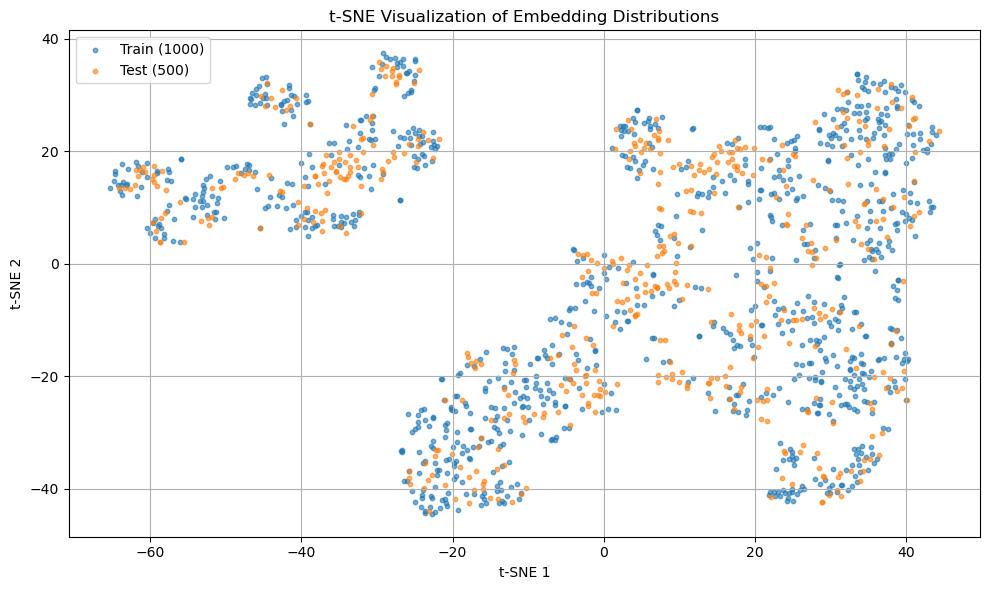

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Random sampling
np.random.seed(40)  # for reproducibility

train_indices = np.random.choice(train_embeddings.shape[0], 1000, replace=False)
score_indices = np.random.choice(score_embeddings.shape[0], 500, replace=False)

subset_train = train_embeddings[train_indices]
subset_score = score_embeddings[score_indices]

# Stack the data for joint TSNE projection
combined_embeddings = np.vstack([subset_train, subset_score])
labels = np.array([0] * 1000 + [1] * 500)  # 0 = train, 1 = test

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
reduced = tsne.fit_transform(combined_embeddings)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(reduced[labels == 0, 0], reduced[labels == 0, 1], alpha=0.6, label='Train (1000)', s=10)
plt.scatter(reduced[labels == 1, 0], reduced[labels == 1, 1], alpha=0.6, label='Test (500)', s=10)
plt.legend()
plt.title("t-SNE Visualization of Embedding Distributions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# Apply PCA before t-SNE

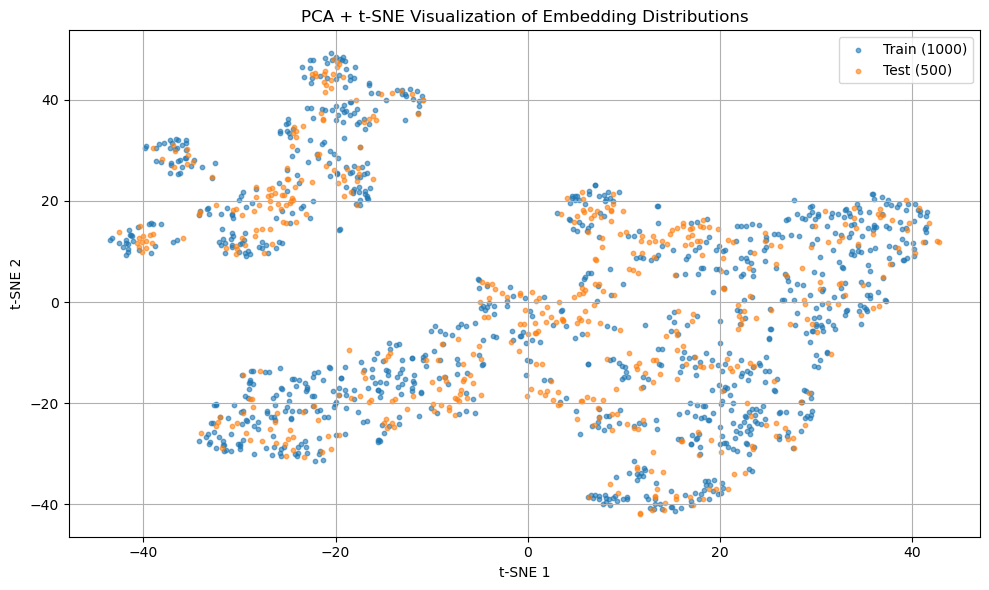

In [15]:
from sklearn.decomposition import PCA
np.random.seed(40)

train_indices = np.random.choice(train_embeddings.shape[0], 1000, replace=False)
score_indices = np.random.choice(score_embeddings.shape[0], 500, replace=False)

subset_train = train_embeddings[train_indices]
subset_score = score_embeddings[score_indices]

# Combine and label the data
combined_embeddings = np.vstack([subset_train, subset_score])
labels = np.array([0] * 1000 + [1] * 500)  # 0 = train, 1 = test

# PCA to reduce to 50D (denoise + speed up)
pca = PCA(n_components=50, random_state=42)
pca_embeddings = pca.fit_transform(combined_embeddings)

# t-SNE
tsne = TSNE(n_components=2, init='random', random_state=42)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings[labels == 0, 0], tsne_embeddings[labels == 0, 1],
            alpha=0.6, label='Train (1000)', s=10)
plt.scatter(tsne_embeddings[labels == 1, 0], tsne_embeddings[labels == 1, 1],
            alpha=0.6, label='Test (500)', s=10)
plt.legend()
plt.title("PCA + t-SNE Visualization of Embedding Distributions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()

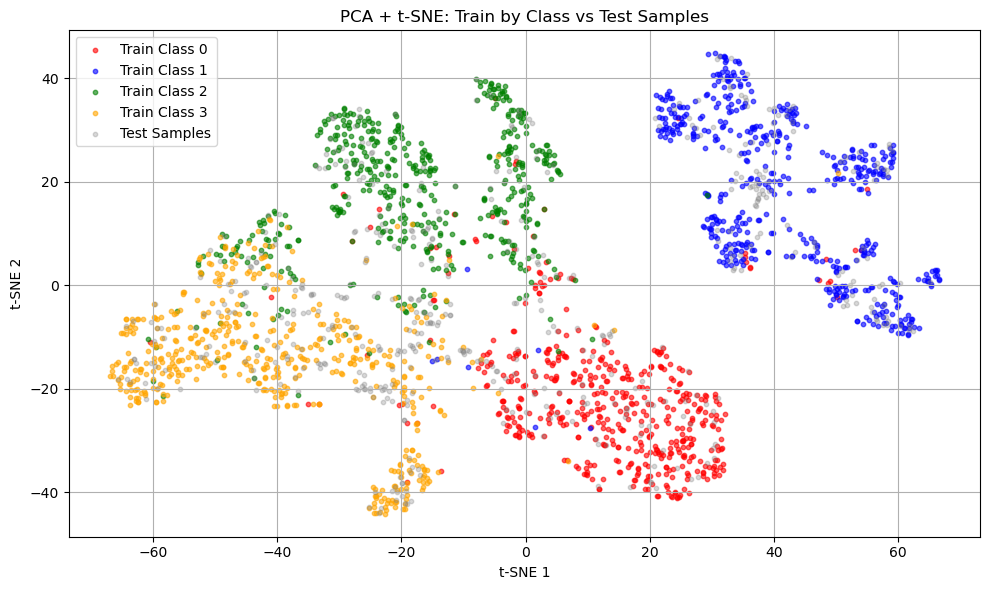

In [ ]:
from collections import defaultdict
# Set random seed for reproducibility
np.random.seed(40)

# Stratified sampling of 500 samples per class from train_dataset
label_to_indices = defaultdict(list)
for idx, label in enumerate(train_dataset['labels']):
    label_to_indices[label].append(idx)

selected_train_indices = []
for label in sorted(label_to_indices.keys()):
    indices = np.random.choice(label_to_indices[label], 500, replace=False)
    selected_train_indices.extend(indices)

selected_train_embeddings = train_embeddings[selected_train_indices]
selected_train_labels = np.array(train_dataset['labels'])[selected_train_indices]

# Randomly sample 500 test embeddings
score_indices = np.random.choice(score_embeddings.shape[0], 500, replace=False)
selected_score_embeddings = score_embeddings[score_indices]

# Combine data for joint visualization
combined_embeddings = np.vstack([selected_train_embeddings, selected_score_embeddings])
color_labels = np.concatenate([selected_train_labels, [-1] * 500])  # -1 = test data

# PCA to 50D
pca = PCA(n_components=50, random_state=42)
pca_embeddings = pca.fit_transform(combined_embeddings)

# t-SNE
tsne = TSNE(n_components=2, init='random', random_state=42)
tsne_embeddings = tsne.fit_transform(pca_embeddings)


plt.figure(figsize=(10, 6))
cmap = ['red', 'blue', 'green', 'orange']  # colors for class 0–3

# Plot training samples by class
for class_id in range(4):
    idxs = np.where(color_labels == class_id)[0]
    plt.scatter(tsne_embeddings[idxs, 0], tsne_embeddings[idxs, 1],
                label=f'Train Class {class_id}', alpha=0.6, s=10, color=cmap[class_id])

# Plot test samples
test_idxs = np.where(color_labels == -1)[0]
plt.scatter(tsne_embeddings[test_idxs, 0], tsne_embeddings[test_idxs, 1],
            label='Test Samples', alpha=0.3, s=10, color='gray')

plt.title("PCA + t-SNE: Train by Class vs Test Samples")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# TSNE nearest neighbors
For the "leakage train" that weights more on samples that are close to the test set.

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Combine data for joint visualization
combined_embeddings = np.vstack([train_embeddings, score_embeddings])

# PCA to 50D
pca = PCA(n_components=5, random_state=42)
pca_embeddings = pca.fit_transform(combined_embeddings)

# t-SNE to 2D
tsne = TSNE(n_components=3, init='random', random_state=42)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

In [17]:
tsne_train_embeddings = tsne_embeddings[0:train_embeddings.shape[0]]
tsne_test_embeddings = tsne_embeddings[train_embeddings.shape[0]:]

In [18]:
tsne_train_embeddings.shape, tsne_test_embeddings.shape

((119360, 3), (8000, 3))

In [19]:
from sklearn.neighbors import NearestNeighbors

k = 10
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(train_embeddings)
distances, neighbor_indices = nbrs.kneighbors(score_embeddings)

# Flatten to get a unique set of close training sample indices
close_train_indices = np.unique(neighbor_indices.flatten())


In [20]:
np.save("neighbor_indices", neighbor_indices)

Example usage

In [6]:
import numpy as np
K = 3
neighbor_indices = np.load("neighbor_indices.npy")
close_train_indices = np.unique(neighbor_indices[:,0:K].flatten())